In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


In [13]:
file_list = glob('../data/*')

stocks = pd.DataFrame()

stock_list = []
for file_name in file_list: 
    try: 
        curr_stock = pd.read_json(file_name)

        
        curr_stock['t'] = pd.to_datetime(curr_stock['t'], unit = 's')
        file_name = file_name.split('\\')[-1].split('.')[0]

        stock_list.append(file_name)
        temp = pd.DataFrame({
            'time' : curr_stock['t'],
            f'{file_name}_price' : curr_stock['c']
        })
        if stocks.empty: 
            stocks = temp
        else: 
            stocks = pd.merge(stocks, temp, how='left', on='time') 
    except Exception as e: 
        print(f"reading {file_name} gives ERROR: {e}")

reading ../data\AKASH.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\BLUECHIP.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\NARMADA.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\NIRAJISPAT.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\SANCO.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\SHAH.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\SRGHFL.json gives ERROR: If using all scalar values, you must pass an index
reading ../data\YASHO.json gives ERROR: If using all scalar values, you must pass an index


In [16]:
train_stocks = stocks.iloc[:int(0.75*(len(stocks)))]
test_stocks = stocks.iloc[int(0.75*(len(stocks))):]

In [18]:
import numpy as np

In [34]:
def support_resistance(df, WINDOW=21, res_tol = 0.2, sup_tol = 0.2, res_count = 2, sup_count = 3): 
    df['support_level'] = pd.Series(np.zeros(len(df)))
    df['resistance_level'] = pd.Series(np.zeros(len(df)))
    df['support_tolerance'] = pd.Series(np.zeros(len(df)))
    df['resistance_tolerance'] = pd.Series(np.zeros(len(df)))
    # df['support_count'] = pd.Series(np.zeros(len(df)))
    # df['resistance_count'] = pd.Series(np.zeros(len(df)))
    df['positions'] = pd.Series(np.zeros(len(df)))
    df['signal'] = pd.Series(np.full(len(df), fill_value=-1))
    
    count_hit_resistance = 0
    count_hit_support = 0
    
    for x in range((WINDOW - 1) + WINDOW, len(df)): 
        data_section = df.iloc[x - WINDOW : x+1]
        # take the support by taking the minimum of the last WINDOW days
        sup = min(data_section['price'])
        # take the resistance by taking the maximum of the last WINDOW days
        res = max(data_section['price'])

        diff = res - sup 

        # store in dataframe
        df['support_level'][x] = sup
        df['resistance_level'][x] = res
        df['support_tolerance'][x] = sup + sup_tol*diff
        df['resistance_tolerance'][x] = res - res_tol*diff

        curr_price = df['price'][x]

        # update how many times we reach the tolerance bands
        if curr_price >= df['resistance_tolerance'][x] and\
            curr_price <= df['resistance_level'][x]: 
            
            count_hit_resistance += 1

        elif curr_price >= df['support_level'][x] and\
            curr_price <= df['support_tolerance'][x]: 

            count_hit_support += 1
        
        else: 
            count_hit_support = 0
            count_hit_resistance = 0
        
        # if we reach enough no. of times, we take a postion.

        if count_hit_resistance > res_count: 
            df['signal'][x] = 1                                # sell
        elif count_hit_support > sup_count: 
            df['signal'][x] = 0                                # buy
        else : 
            df['signal'][x] = -1


    return df

C:\Users\esnd1\AppData\Local\Temp\ipykernel_19228\2470893950.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['support_level'][x] = sup
C:\Users\esnd1\AppData\Local\Temp\ipykernel_19228\2470893950.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resistance_level'][x] = res
C:\Users\esnd1\AppData\Local\Temp\ipykernel_19228\2470893950.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['support_tolerance'][x] = sup + s

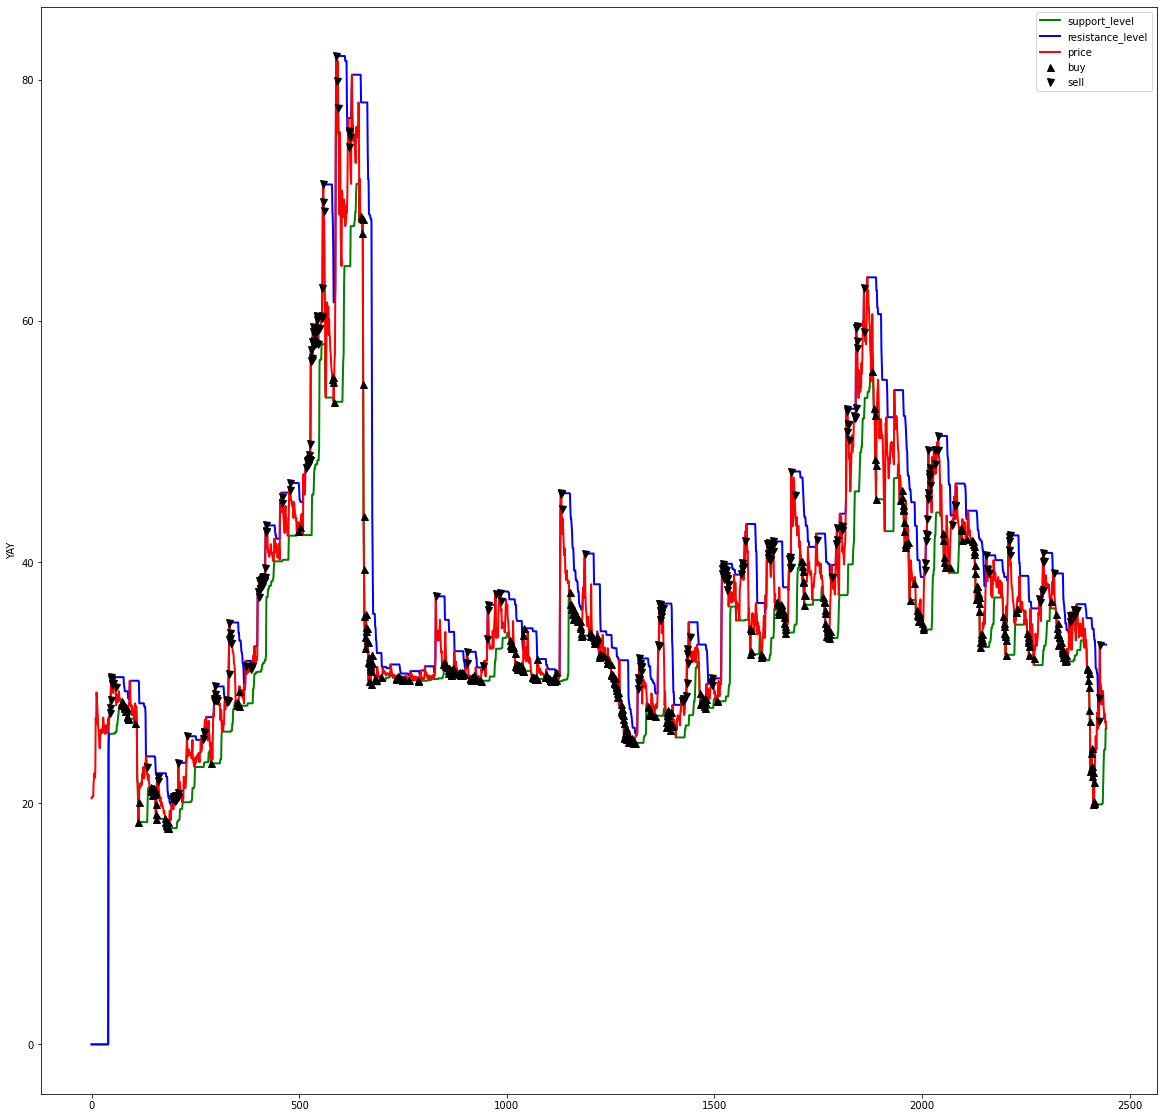

,price,support_level,resistance_level,support_tolerance,resistance_tolerance,positions,signal,pnl
0,20.40,0.00,0.00,0.00,0.00,0.0,-1,0.0
1,20.50,0.00,0.00,0.00,0.00,0.0,-1,0.0
2,20.55,0.00,0.00,0.00,0.00,0.0,-1,0.0
3,20.60,0.00,0.00,0.00,0.00,0.0,-1,0.0
4,20.55,0.00,0.00,0.00,0.00,0.0,-1,0.0
...,...,...,...,...,...,...,...,...
2439,27.05,24.45,33.15,26.19,31.41,12.0,-1,2152.3
2440,27.40,24.45,33.15,26.19,31.41,12.0,-1,2152.3
2441,26.70,24.45,33.15,26.19,31.41,12.0,-1,2152.3
2442,26.80,26.20,33.15,27.59,31.76,12.0,-1,2152.3


In [47]:
# testing on 20MICRONS 

def test_support_resistance_algo(file_name, stocks, max_increments = 1, buy_at_once = 1): 
    df = pd.DataFrame({'price': stocks[f'{file_name}_price']})
    df = support_resistance(df, res_tol=0.2, sup_tol= 0.2)

    #  0 --> no stocks , 1 --> hold stock, -1 --> short stock
    curr_pos = 0
    pnl = 0
    
    df['pnl'] = pd.DataFrame(np.zeros(len(df)))

    for i in range(len(df)):     
        if df['signal'][i] == 1 and curr_pos > -max_increments: 
            # sell 
            curr_pos -= 1
            pnl += buy_at_once*df['price'][i]
        elif df['signal'][i] == 0 and curr_pos < max_increments:  
            # buy
            curr_pos += 1
            pnl -= buy_at_once*df['price'][i]
        df['pnl'][i] = pnl 
        df['positions'][i] = curr_pos

    
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(111, ylabel = 'YAY')
    df['support_level'].plot(ax=ax1, color='g', lw=2.)
    df['resistance_level'].plot(ax=ax1, color='b', lw=2.)
    df['price'].plot(ax=ax1, color='r', lw=2.)
    ax1.plot(df.loc[df.signal == 0].index,
        df.price[df.signal == 0],
        '^', markersize=7, color='k',label='buy')
    ax1.plot(df.loc[df.signal == 1].index,
        df.price[df.signal == 1],
        'v', markersize=7, color='k',label='sell')
    plt.legend()
    plt.show()


    return df

test_support_resistance_algo(stock_list[0], train_stocks, max_increments = 15, buy_at_once = 10)